# ddm-RL Model Fitting

## Section 1: Motivating the model
### Reaction time effects

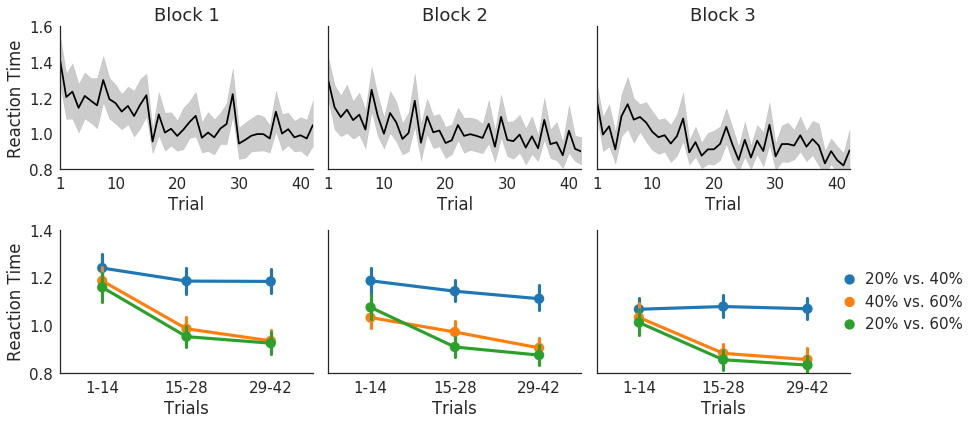

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Categorical, DataFrame, read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]

## Define trial types (e.g. 20% vs. 40%).
cond = np.where(data[['M1','M2']] % 3, data[['M1','M2']] % 3, 3).sum(axis=1)
cond = Categorical(cond, categories=[3,5,4], ordered=True).rename_categories(['20% vs. 40%', 
                                                                              '40% vs. 60%', 
                                                                              '20% vs. 60%'])
data['Cond'] = cond

## Bin trials into thirds.
data['Bins'] = (data.Trial - 1) // 14

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, 3, figsize=(12,6))

## Plot.
for i in np.arange(3):
    
    ## Plot RT timeseries.
    sns.lineplot('Trial', 'RT', data=data[data.Block==i+1], color='k', zorder=0, ax=axes[0,i])
    ax=axes[0,i].set(xlim=(1,42), xticks=[1,10,20,30,40], ylim=(0.8,1.6), 
                     yticks=[], ylabel='', title='Block %s' %(i+1))
    if not i: axes[0,i].set(yticks=np.arange(0.8,1.7,0.2), ylabel='Reaction Time')

    ## Plot RT bins.
    sns.pointplot('Bins', 'RT', 'Cond', data=data[data.Block==i+1], ax=axes[1,i])
    axes[1,i].set(xticklabels=['1-14','15-28','29-42'], xlabel='Trials', ylim=(0.8,1.4),
                  yticks=[], ylabel='')
    axes[1,i].legend_.set_visible(False)
    if not i: axes[1,i].set(yticks=np.arange(0.8,1.5,0.2), ylabel='Reaction Time')

axes[1,2].legend(loc=7,bbox_to_anchor=(1.5,0.5),handletextpad=0)
        
sns.despine()
plt.tight_layout()

### Sources of speed-up

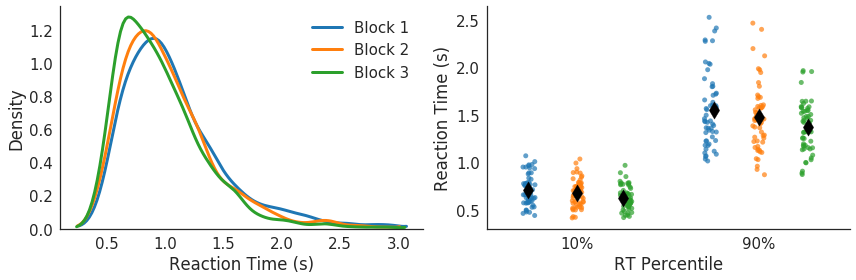

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Set True you want to include post-query trials.
## Does not make a major effect.
mask = False
query_trials = [8,15,22,29,36]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare percentile data (10%, 90%).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if mask: perc = data[[True if t not in query_trials else False for t in data.Trial]].copy()
else: perc = data.copy()
    
## Compute percentile data.
perc = perc.groupby(['Block','Datetime']).RT.apply(lambda arr: np.nanpercentile(arr, [10,90])).reset_index()
perc['10%'] = perc.RT.apply(lambda arr: arr[0])
perc['90%'] = perc.RT.apply(lambda arr: arr[1])

## Melt and reshape DataFrame for plotting.
perc = perc.drop('RT', 1).melt(id_vars=('Block','Datetime'), var_name='Percentile', value_name='RT')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot KDE.
for i in np.arange(3): sns.kdeplot(data.loc[data.Block==i+1,'RT'].dropna(), lw=3, cut=1,
                                   label='Block %s' %(i+1), ax=axes[0])
axes[0].set(xlabel='Reaction Time (s)', ylabel='Density')
    
## Plot stripplot.
sns.stripplot('Percentile', 'RT', 'Block', data=perc, dodge=True, jitter=True, alpha=0.7, ax=axes[1])
axes[1].scatter([-0.27,0,0.25,0.75,1,1.27], perc.groupby(['Percentile','Block']).RT.mean().values,
                s=150, marker='d', color='k', zorder=100)
axes[1].set(xlabel='RT Percentile', ylabel='Reaction Time (s)')
axes[1].legend_.set_visible(False)

sns.despine()
plt.tight_layout()

In [3]:
from spm1d.stats import anova1rm

for p in perc.Percentile.unique():

    ## Prepare data.
    ix, = np.where(perc.Percentile==p)
    Y = perc.loc[ix, 'RT'].values
    _, A = np.unique(perc.loc[ix, 'Block'], return_inverse=True)
    _, SUBJ = np.unique(perc.loc[ix, 'Datetime'], return_inverse=True)
    
    ## Fit 1-way repeated measures ANOVA.
    fit = anova1rm(Y, A, SUBJ).inference(alpha=0.05)
    print('%s RT: F = %0.3f, p = %0.3f' %(p, fit.z, fit.p))

10% RT: F = 19.985, p = 0.000
90% RT: F = 9.962, p = 0.000


### Task-switching

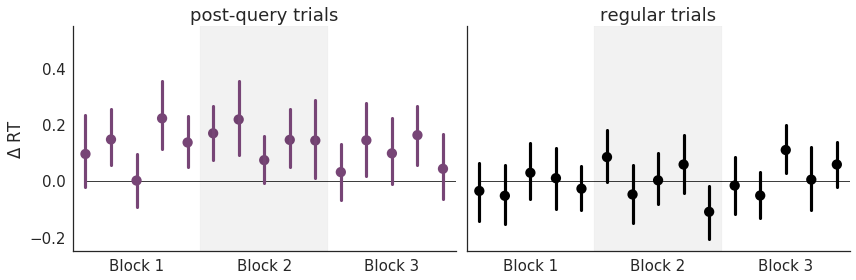

In [4]:
query_trials = np.array([8,15,22,29,36])

## Reshape RT data.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
RT = data.RT.values.reshape(N,B,T)

## 
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)

for i, ax, color, title in zip(range(2), axes, ['#774576','k'], ['post-query trials', 'regular trials']):

    query_trials += i * 3
    
    ## Preallocate space.
    penalty = np.zeros((N,B,len(query_trials)))

    ## Iteratively compute RT penalty.
    for j, qt in enumerate(query_trials):
        penalty[...,j] = RT[...,qt-1] - RT[...,[qt-2,qt]].mean(axis=-1)

    ## Convert to DataFrame.
    penalty = DataFrame(penalty.reshape(N,B*len(query_trials)))
    penalty = penalty.melt(var_name='Query', value_name='RT')
    
    ## Plot.
    sns.pointplot('Query', 'RT', data=penalty, join=False, color=color, ax=ax)
    ax.hlines(0,0,15,zorder=0,lw=0.75)
    ax.fill_between([4.5,9.5],-0.25,0.55,color='k',alpha=0.05)
    ax.set(xticks=np.arange(2,15,5), xticklabels=['Block 1', 'Block 2', 'Block 3'],
           xlabel='', ylim=(-0.25,0.55), ylabel='', title=title)
    if not i: ax.set_ylabel(r'$\Delta$ RT')
        
sns.despine()
plt.tight_layout()

## Section 2: Model Fitting

In [ ]:
import os, pystan
import numpy as np
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = 'ddmRL_ppool_base.stan'

## Sampling parameters.
samples = 500
warmup = 250
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()

## Extract and prepare stimulus presentation data.
## Stimulus presentation is sorted such that the
## more valuable machine occupies the right column.
X = data[['M1','M2']].values.reshape(N,B*T,2)
X = np.sort(X, axis=-1) 

## Extract and prepare choice data. Choice data 
## recoded to range [1, 2], where 1 = less valuable, 
# 2 = more valuable. Missing values coded as -1.
Y = data.Choice.values.reshape(N,B*T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )

## Extract and prepare RT data.
Z = data.RT.values.reshape(N,B*T)
minRT = np.nanmin(np.where(Z < 0, np.nan, Z), axis=1)
if np.any(minRT < 0.2): raise ValueError('WARNING: Min RTs too low!')
    
## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values.reshape(N,B*T)
R = np.where(R > 0, 1, 0)

## Define index of post-query trials.
ix = np.zeros(B*T, dtype=int)
ix[[ 7, 14, 21, 28, 35, 49, 56, 63, 70, 77, 91,  98, 105, 112, 119]] = 1

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, T=T*B, X=X, Y=Y, Z=Z, R=R, ix=ix, minRT=minRT)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Define control parameters.
    if 'orig' in model_name: control = dict(adapt_delta = 0.9)
    else: control = None
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, 
                      chains=chains, control=control, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
#     summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
#     with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

In [ ]:
%%notify
summary[summary.Rhat > 1.1]

In [ ]:
fit

In [ ]:
from scripts.wiener import wiener_rng

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Posterior predictive checks.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract samples.
extract = fit.extract()
alpha = extract['alpha'][:,1]
tau = extract['tau_b'][:,1]
drift = extract['drift'][:,1]

## RNG.
Z_pred = np.zeros_like(drift)
Y_pred = np.zeros_like(drift)

n_samp, n_trial = Z_pred.shape
for i in np.arange(n_samp):
    for j in np.arange(n_trial):
        Z_pred[i,j], Y_pred[i,j] = wiener_rng(alpha[i], tau[i], 0.5, drift[i,j])
            
## Swap all 1s and 2s.
Y_pred = 3 - Y_pred

In [ ]:
sns.kdeplot(Z[1], shade=True)
for arr in Z_pred: sns.kdeplot(arr.flatten(), color='r', alpha=0.005)
plt.xlim(0,3)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))

## Plot choice ppc. 
ax = plt.subplot2grid((2,2),(0,0))
Y_ppc = np.array([np.equal(Y,y) for y in Y_pred]).mean(axis=0)
sns.distplot(Y_ppc.flatten(), bins=np.arange(0,1.1,0.1), kde=False, 
             hist_kws=dict(edgecolor='w'), ax=ax)
ax.set(xlabel='Fraction Correct Predictions', ylabel='Count', title='Posterior Predictive Check: Choice')

## Plot RT ppc.
ax = plt.subplot2grid((2,2),(0,1))
sns.kdeplot(Z.flatten(), shade=True, ax=ax)
for arr in Z_pred: sns.kdeplot(arr.flatten(), color='r', alpha=0.005, ax=ax)
ax.set(xlabel='Reaction Time', xlim=(0,3), ylabel='Density', title='Posterior Predictive Check: RT')
    
## Plot RT timeseries.
ax = plt.subplot2grid((2,2),(1,0),colspan=2)
ax.plot(Z.flatten(), color='grey', label='Observed')
ax.plot(np.median(Z_pred, axis=0).flatten(), lw=2.5, label='Estimated')
ax.vlines([42,84], 0.5, 2.5, lw=3, color='k', zorder=90)
ax.set(xlim=(0,126), xlabel='Trial', ylim=(0.5,2.5), ylabel='RT')
ax.legend(loc=2, borderpad=0)
    
sns.despine()
plt.tight_layout()